<a href="https://colab.research.google.com/github/Matan231/Using-Deep-Reinforenment-Learning-methods-for-solving-OpenAI-s-Highway-Environments/blob/main/RL_Final_Project_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Reinforcements Learning


---
<br>

Student 1: Ophir Benjamin
<br>
Student 2: Matan Velner
<br><br>


## Installs and Imports

In [ ]:
!pip install highway-env
!pip install git+https://github.com/DLR-RM/stable-baselines3
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
!git clone https://github.com/eleurent/highway-env.git 2> /dev/null
!git clone https://github.com/avivg7/highway-config.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DLR-RM/stable-baselines3 to /tmp/pip-req-build-2iz8r82x
  Running command git clone -q https://github.com/DLR-RM/stable-baselines3 /tmp/pip-req-build-2iz8r82x
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
fatal: destination path 'highway-config' 

In [ ]:
import gym
import highway_env
import sys
sys.path.insert(0, '/content/highway-env/scripts/')
from tqdm.notebook import trange
from utils import record_videos, show_videos
import numpy as np
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import io
import base64
import os
import random
import matplotlib.pyplot as plt
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import json
import ast
%load_ext tensorboard
%matplotlib inline

In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import cv2
from torch.distributions.categorical import Categorical

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

Device is cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# Utils

In [ ]:
# These are helper functions to visualize data during and after the learning process

def display_setp_hist(returns_hist, steps_hist):
  num_epochs = len(returns_hist)
  x = np.arange(0, num_epochs)
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.plot(x, returns_hist, 'g-')
  ax2.plot(x, steps_hist, 'b-')
  ax1.set_xlabel('Episodes')
  ax1.set_ylabel(' AVG rps', color='g')
  ax2.set_ylabel('Steps', color='b')

  plt.show()

def display_icm_hist(icm_loss_hist, r_i_t_hist):
  num_epochs = len(icm_loss_hist)
  x = np.arange(0, num_epochs)
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.plot(x, icm_loss_hist, 'g-')
  ax2.plot(x, r_i_t_hist, 'b-')
  ax1.set_xlabel('Episodes')
  ax1.set_ylabel('ICM Loss', color='g')
  ax2.set_ylabel('Int. Reward', color='b')

  plt.show()

def display_returns_hist(returns_hist):
  num_epochs = len(returns_hist)
  x = np.arange(0, num_epochs)
  fig, ax1 = plt.subplots()
  ax1.plot(x, returns_hist, 'g-')
  ax1.set_xlabel('Episodes')
  ax1.set_ylabel('Return', color='g')

  plt.show()

def create_video(agent, env, repeat=1, stochastic_env=False,  max_steps = 500, is_ppo = False):
  env = wrap_env(env)
  prev_observision = env.reset()
  done = False
  step = 0
  max_steps = min(max_steps, 500)
  if is_ppo:
    agent.actor.eval()
    agent.critic.eval()
  else:
    agent.Q.eval()
  repeation_total_reward = 0

  while (step < max_steps) and not done:
    with torch.no_grad():
      if is_ppo:
        action,_,_ = agent.sample_action(prev_observision)
        print(action)
      else:
        action = agent.sample_action(prev_observision, eval_mode=True)


      for i in range(repeat):
        repeated_action = action
        if stochastic_env:
          repeated_action = stochastic_transition(action)

        cur_observation, reward, done, info = env.step(repeated_action)
        repeation_total_reward += reward

        #print(f'iteration: {iter}, action: {action}, reward: {reward}, done: {done}')
        #print(info)
        step +=1
        if step >= max_steps:
          done = True
        if done:
          break

      prev_observision = cur_observation


  env.close()
  show_video()

In [ ]:
def stochastic_transition(action):
  if np.random.random() < 0.85:
    return action
  else:
    return (action + random.randint(1, 4)) % 5

In [ ]:
def display_stats(stats_info, head_line):
  sliding_window_size = 50

  return_hist = stats_info['return_hist']
  rps_hist = stats_info['rps_hist']
  steps_hist = stats_info['steps_hist']
  icm_loss_hist = stats_info['icm_loss_hist']
  r_i_t_hist = stats_info['r_i_t_hist']

  return_avg = np.convolve(np.array(return_hist), np.ones(sliding_window_size)/sliding_window_size, mode='valid')
  rps_avg = np.convolve(np.array(rps_hist), np.ones(sliding_window_size)/sliding_window_size, mode='valid')
  steps_avg = np.convolve(np.array(steps_hist), np.ones(sliding_window_size)/sliding_window_size, mode='valid')
  icm_loss_avg = np.convolve(np.array(icm_loss_hist), np.ones(sliding_window_size)/sliding_window_size, mode='valid')
  r_i_t_avg = np.convolve(np.array(r_i_t_hist), np.ones(sliding_window_size)/sliding_window_size, mode='valid')

  print(head_line)
  display_setp_hist(rps_avg, steps_avg)
  display_returns_hist(return_avg)
  display_icm_hist(icm_loss_avg, r_i_t_avg)
  print(f"Total number of Episods: {len(steps_hist)}")
  print(f"Total number of steps: {sum(steps_hist)}")

# Components

## Networks

### DQN Networks

In [ ]:
# Class for the CNN used by the agents
class DQN_Net2(nn.Module):
  def __init__(self, lr, obs_shape, name="DQN.pt", chkpt_dir="/content/drive/MyDrive/RL_FINAL"):
    super(DQN_Net2, self).__init__()

    self.checkpoint_dir = chkpt_dir
    self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

    self.conv0 = nn.Conv2d(4, 4, 3, stride=2, padding=1)
    self.conv1 = nn.Conv2d(4, 32, 8, stride=4)
    self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
    self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

    state = torch.zeros(1, 4, obs_shape[1], obs_shape[2])
    dims = self.conv1(state)
    dims = self.conv2(dims)
    dims = self.conv3(dims)
    fc_input_dims = int(np.prod(dims.size()))
    print(fc_input_dims)

    self.fc1 = nn.Linear(fc_input_dims, 512)
    self.fc2 = nn.Linear(512, 5)

    self.optimizer = optim.Adam(self.parameters(), lr=lr, eps = 1.5e-04)

    self.criterion = nn.MSELoss()
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
    state = state.type(torch.float32)

    conv1 = F.relu(self.conv1(state))
    conv2 = F.relu(self.conv2(conv1))
    conv3 = F.relu(self.conv3(conv2))
    conv_state = conv3.view(conv3.size()[0], -1)

    flat1 = F.relu(self.fc1(conv_state))
    actions = self.fc2(flat1)

    return actions

  def save_checkpoint(self, verbose=True):
    if verbose:
      print('... saving checkpoint ...')
    torch.save(self.state_dict(), self.checkpoint_file)

  def load_checkpoint(self, file_name=None):
    if file_name == None:
      self.load_state_dict(torch.load(self.checkpoint_file))
    else:
      self.load_state_dict(torch.load(file_name))

In [ ]:
class DuelingDQN_Net(nn.Module):
  def __init__(self, lr, obs_shape, name="DuelingDQN.pt", chkpt_dir="/content/drive/MyDrive/RL_FINAL"):
    super(DuelingDQN_Net, self).__init__()

    self.checkpoint_dir = chkpt_dir
    self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

    self.conv1 = nn.Conv2d(4, 32, 8, stride=4)
    self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
    self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm1d(512)

    state = torch.zeros(1, 4, obs_shape[1], obs_shape[2])
    dims = self.conv1(state)
    dims = self.conv2(dims)
    dims = self.conv3(dims)
    fc_input_dims = int(np.prod(dims.size()))

    self.fc1 = nn.Linear(fc_input_dims, 512)
    self.Adv = nn.Linear(512, 5)
    self.Val = nn.Linear(512, 1)

    self.optimizer = optim.Adam(self.parameters(), lr=lr, eps=1.5e-04)

    self.criterion = nn.MSELoss()
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
    state = state.type(torch.float32)

    conv1 = F.relu(self.conv1(state))
    conv2 = F.relu(self.conv2(conv1))
    conv3 = F.relu(self.conv3(conv2))
    conv_state = conv3.view(conv3.size()[0], -1)

    flat1 = F.relu(self.fc1(conv_state))
    advantage = self.Adv(flat1)
    value = self.Val(flat1)

    Q = value + advantage - advantage.mean(dim=1, keepdim=True)

    return Q

  def save_checkpoint(self, verbose=True):
    if verbose:
      print('... saving checkpoint ...')
    torch.save(self.state_dict(), self.checkpoint_file)

  def load_checkpoint(self, file_name=None):
    print('... loading checkpoint ...')
    if file_name == None:
      self.load_state_dict(torch.load(self.checkpoint_file))
    else:
      self.load_state_dict(torch.load(file_name))

In [ ]:
class DuelingDQN_Net2(nn.Module):
  def _init_(self, lr, obs_shape, name="DuelingDQN.pt", chkpt_dir="/content/drive/MyDrive/RL_FINAL"):
    super(DuelingDQN_Net2, self)._init_()

    self.checkpoint_dir = chkpt_dir
    self.checkpoint_file = os.path.join(self.checkpoint_dir, name)


    self.convs = nn.Sequential(nn.Conv2d(4, 16, 3, stride=1, padding=1), nn.ReLU(), # 16X160X64
                  nn.MaxPool2d(2,2), # 16X80X32
                  nn.Conv2d(16,32,3,1, padding=1), nn.ReLU(), # 32X80X32
                  nn.MaxPool2d(2,2), # 32X40X16
                  nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(), # 64X40X16
                  nn.MaxPool2d(2,2), # 64X20X8
                  nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.ReLU(),  # 128X20X8
                  nn.MaxPool2d(2,2) # 128X10X4
                  )

    state = torch.zeros(1, 4, obs_shape[1], obs_shape[2])
    dims = self.convs(state)
    fc_input_dims = int(np.prod(dims.size()))

    self.fc1 = nn.Linear(fc_input_dims, 512)
    self.Adv = nn.Linear(512, 5)
    self.Val = nn.Linear(512, 1)

    self.optimizer = optim.Adam(self.parameters(), lr=lr, eps=1.5e-04)

    self.criterion = nn.MSELoss()
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
    state = state.type(torch.float32)

    x = self.convs(state)
    conv_state = x.view(x.size()[0], -1)

    flat1 = F.relu(self.fc1(conv_state))
    advantage = self.Adv(flat1)
    value = self.Val(flat1)

    Q = value + advantage - advantage.mean(dim=1, keepdim=True)

    return Q

  def save_checkpoint(self, verbose=True):
    if verbose:
      print('... saving checkpoint ...')
    torch.save(self.state_dict(), self.checkpoint_file)

  def load_checkpoint(self, file_name=None):
    print('... loading checkpoint ...')
    if file_name == None:
      self.load_state_dict(torch.load(self.checkpoint_file))
    else:
      self.load_state_dict(torch.load(file_name))

In [ ]:
#we have tried networks architctures

# # Class for the CNN used by the agents
# class DQN_Net(nn.Module):
#   def __init__(self, learning_rate, name="DQN.pt", chkpt_dir="/content/drive/MyDrive/RL_FINAL"):
#       super(DQN_Net, self).__init__()
#       self.checkpoint_dir = chkpt_dir
#       self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

#       num_actions = 5
#       fc_size = 512
#       step1_size = 32
#       step2_size = 64
#       step3_size = 128
#       step4_size = 256
#       step5_size = 128

#       self.pool = nn.MaxPool2d(2,2)

#       self.conv1 = nn.Conv2d(4 ,step1_size ,3, padding=1)
#       # pool
#       self.bn1 = nn.BatchNorm2d(step1_size)

#       self.conv2 = nn.Conv2d(step1_size ,step2_size ,3, padding=1)
#       # pool
#       self.bn2 = nn.BatchNorm2d(step2_size)

#       self.conv3 = nn.Conv2d(step2_size ,step3_size ,3, padding=1)
#       # pool
#       self.bn3 = nn.BatchNorm2d(step3_size)

#       self.conv4 = nn.Conv2d(step3_size ,step4_size ,3, padding=1)
#       # pool
#       self.bn4 = nn.BatchNorm2d(step4_size)

#       self.conv5 = nn.Conv2d(step4_size ,step5_size ,1)
#       # pool

#       self.fc1 = nn.Linear(step5_size * 8 * 8 , fc_size)
#       self.fc2 = nn.Linear(fc_size, num_actions)

#       self.criterion = nn.MSELoss()
#       self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
#       self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#   def forward(self, x):
#       x = x.type(torch.float32)             # 128 * 128 * 4

#       x = self.pool(F.relu(self.conv1(x)))  # 64 * 64 * 32
#       x = self.bn1(x)

#       x = self.pool(F.relu(self.conv2(x)))  # 32 * 32 * 64
#       x = self.bn2(x)

#       x = self.pool(F.relu(self.conv3(x)))  # 16 * 16 * 128
#       x = self.bn3(x)

#       x = self.pool(F.relu(self.conv4(x))) # 8 * 8 * 256
#       x = self.bn4(x)

#       x = F.relu(self.conv5(x))             # 8 * 8 * 128
#       x = torch.flatten(x, 1)               # 8192 * 1 * 1
#       x = F.relu(self.fc1(x))
#       x = self.fc2(x)
#       return x


#   def save_checkpoint(self, verbose=True):
#     print('... saving checkpoint ...')
#     torch.save(self.state_dict(), self.checkpoint_file)

#   def load_checkpoint(self):
#     print('... loading checkpoint ...')
#     self.load_state_dict(torch.load(self.checkpoint_file))

### ICM Network

In [ ]:
class ICM(nn.Module):
  def __init__(self, name="ICM.pt", chkpt_dir="/content/drive/MyDrive/RL_FINAL", lr = 0.001, beta = 0.2, alpha = 1.0):
    super(ICM, self).__init__()

    self.checkpoint_dir = chkpt_dir
    self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

    self.lr = lr
    self.beta = beta
    self.alpha = alpha

    #self.conv0 = nn.Conv2d(4, 4, 3, stride=2, padding=1)
    self.conv1 = nn.Conv2d(4, 32, 3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
    self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
    self.conv5 = nn.Conv2d(32, 16, 3, stride=2, padding=1)

    self.inv1 = nn.Linear(512, 256)
    self.inv2 = nn.Linear(256, 5)

    self.forward1 = nn.Linear(256+1, 256)
    self.forward2 = nn.Linear(256, 256)

    self.optimizer = optim.Adam(self.parameters(), lr=lr)

  def forward(self, state, action, next_state):
    state = state.type(torch.float32)             # 1 x 4 x 128 x 128
    next_state = next_state.type(torch.float32)

    #x = F.elu(self.conv0(state))                  # 1 x 4 x 64 x 64

    x = F.elu(self.conv1(state))                   # 1 x 32 x 64 x 64
    x = F.elu(self.conv2(x))                       # 1 x 32 x 32 x 32
    x = F.elu(self.conv3(x))                       # 1 x 32 x 16 x 16
    x = F.elu(self.conv4(x))                       # 1 x 32 x 8 x 8
    state_embd = F.elu(self.conv5(x))              # 1 x 16 x 4 x 4

    #x = F.elu(self.conv0(next_state))
    x = F.elu(self.conv1(next_state))
    x = F.elu(self.conv2(x))
    x = F.elu(self.conv3(x))
    x = F.elu(self.conv4(x))
    next_state_embd = F.elu(self.conv5(x))

    state_embd = torch.flatten(state_embd, 1)
    next_state_embd = torch.flatten(next_state_embd, 1)

    concat_embeds = torch.cat([state_embd, next_state_embd], dim=1)

    x = F.elu(self.inv1(concat_embeds))
    action_scores = self.inv2(x)

    action = action.reshape(action.size()[0],1) # resizeing action
    concat_state_action =  torch.cat([state_embd, action], dim=1)

    x = self.forward1(concat_state_action)
    next_state_pred = self.forward2(x)

    return next_state_pred, action_scores, next_state_embd

  def calc_loss(self, state, action , next_state):

    ce_criterion = nn.CrossEntropyLoss()
    mse_criterion = nn.MSELoss()
    next_state_pred, action_scores, next_state_embd = self.forward(state, action, next_state)

    L_I = (1-self.beta)*ce_criterion(action_scores, action)
    L_F = self.beta*mse_criterion(next_state_pred, next_state_embd)
    loss = L_I + L_F

    intrinsic_reward = self.alpha*(next_state_pred - next_state_embd).pow(2).mean(dim=1)

    return loss, intrinsic_reward

  def save_checkpoint(self, verbose=True):
    if verbose:
      print('... saving checkpoint ...')
    torch.save(self.state_dict(), self.checkpoint_file)

  def load_checkpoint(self):
    print('... loading checkpoint ...')
    self.load_state_dict(torch.load(self.checkpoint_file))

### PPO Networks

In [ ]:
class ActorNetwork(nn.Module):
  def __init__(self, lr, obs_shape, name="DQN.pt", chkpt_dir="/content/drive/MyDrive/RL_FINAL"):
    super(ActorNetwork, self).__init__()

    self.checkpoint_dir = chkpt_dir
    self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

    self.conv0 = nn.Conv2d(4, 4, 3, stride=2, padding=1)
    self.conv1 = nn.Conv2d(4, 32, 8, stride=4)
    self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
    self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

    state = torch.zeros(1, 4, obs_shape[1], obs_shape[2])
    #dims = self.conv0(state)
    dims = self.conv1(state)
    dims = self.conv2(dims)
    dims = self.conv3(dims)
    fc_input_dims = int(np.prod(dims.size()))
    print(fc_input_dims)

    self.fc1 = nn.Linear(fc_input_dims, 512)
    self.fc2 = nn.Linear(512, 5)
    self.softmax = nn.Softmax(dim=-1)

    self.optimizer = optim.Adam(self.parameters(), lr=lr, eps = 1.5e-04)

    self.criterion = nn.MSELoss()
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
    state = state.type(torch.float32)
    #conv0 = F.relu(self.conv0(state))

    conv1 = F.relu(self.conv1(state))
    conv2 = F.relu(self.conv2(conv1))
    conv3 = F.relu(self.conv3(conv2))
    conv_state = conv3.view(conv3.size()[0], -1)

    flat1 = F.relu(self.fc1(conv_state))
    actions = self.fc2(flat1)
    dist = self.softmax(actions)
    dist = Categorical(dist)

    return dist

  def save_checkpoint(self, verbose=True):
    if verbose:
      print('... saving checkpoint ...')
    torch.save(self.state_dict(), self.checkpoint_file)

  def load_checkpoint(self, verbose=True):
    if verbose:
      print('... loading checkpoint ...')
    self.load_state_dict(torch.load(self.checkpoint_file))


In [ ]:
# class CriticNetwork(nn.Module):
#     def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
#             chkpt_dir='tmp/ppo'):
#         super(CriticNetwork, self).__init__()

#         self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
#         self.critic = nn.Sequential(
#                 nn.Linear(*input_dims, fc1_dims),
#                 nn.ReLU(),
#                 nn.Linear(fc1_dims, fc2_dims),
#                 nn.ReLU(),
#                 nn.Linear(fc2_dims, 1)
#         )

#         self.optimizer = optim.Adam(self.parameters(), lr=alpha)
#         self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
#         self.to(self.device)

#     def forward(self, state):
#         value = self.critic(state)

#         return value

#     def save_checkpoint(self):
#         T.save(self.state_dict(), self.checkpoint_file)

#     def load_checkpoint(self):
#         self.load_state_dict(T.load(self.checkpoint_file))

class CriticNetwork(nn.Module):
  def __init__(self, lr, obs_shape, name="DQN.pt", chkpt_dir="/content/drive/MyDrive/RL_FINAL"):
    super(CriticNetwork, self).__init__()

    self.checkpoint_dir = chkpt_dir
    self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

    self.conv1 = nn.Conv2d(4, 32, 8, stride=4)
    self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
    self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

    state = torch.zeros(1, 4, obs_shape[1], obs_shape[2])
    dims = self.conv1(state)
    dims = self.conv2(dims)
    dims = self.conv3(dims)
    fc_input_dims = int(np.prod(dims.size()))
    print(fc_input_dims)

    self.fc1 = nn.Linear(fc_input_dims, 512)
    self.fc2 = nn.Linear(512, 1)

    self.optimizer = optim.Adam(self.parameters(), lr=lr, eps = 1.5e-04)

    self.criterion = nn.MSELoss()
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
    state = state.type(torch.float32)

    conv1 = F.relu(self.conv1(state))
    conv2 = F.relu(self.conv2(conv1))
    conv3 = F.relu(self.conv3(conv2))
    conv_state = conv3.view(conv3.size()[0], -1)

    flat1 = F.relu(self.fc1(conv_state))
    value = self.fc2(flat1)

    return value

  def save_checkpoint(self, verbose=True):
    if verbose:
      print('... saving checkpoint ...')
    torch.save(self.state_dict(), self.checkpoint_file)

  def load_checkpoint(self, verbose=True):
    if verbose:
      print('... loading checkpoint ...')
    self.load_state_dict(torch.load(self.checkpoint_file))


## Replay Buffer

### DQN

In [ ]:
class ReplayBuffer():
  def __init__(self, buffer_size, obs_shape):
    self.buffer_size = buffer_size
    self.counter = 0
    self.state_memory = np.zeros((self.buffer_size, *obs_shape),
                                  dtype=np.uint8)
    self.next_state_memory = np.zeros((self.buffer_size, *obs_shape),
                                      dtype=np.uint8)
    self.action_memory = np.zeros(self.buffer_size, dtype=int)
    self.reward_memory = np.zeros(self.buffer_size, dtype=np.float32)
    self.isdone_memory = np.zeros(self.buffer_size, dtype=bool)

  def store_transition(self, state, action,reward, next_state, done):
    index = self.counter % self.buffer_size
    self.state_memory[index] = state
    self.next_state_memory[index] = next_state
    self.action_memory[index] = action
    self.reward_memory[index] = reward
    self.isdone_memory[index] = done
    self.counter += 1

  def sample_buffer(self, batch_size):
    buffer_current_size = min(self.counter, self.buffer_size)
    batch = np.random.choice(buffer_current_size, batch_size, replace=False)
    states = self.state_memory[batch]
    actions = self.action_memory[batch]
    rewards = self.reward_memory[batch]
    next_state = self.next_state_memory[batch]
    done = self.isdone_memory[batch]

    batch = (states, actions, rewards, next_state, done)
    return batch

  def is_ready(self, batch_size):
    return self.counter >= batch_size


In [ ]:
# The ‘sum-tree’ data structure used here is very similar in spirit to the array representation
# of a binary heap. However, instead of the usual heap property, the value of a parent node is
# the sum of its children. Leaf nodes store the transition priorities and the internal nodes are
# intermediate sums, with the parent node containing the sum over all priorities, p_total. This
# provides a efficient way of calculating the cumulative sum of priorities, allowing O(log N) updates
# and sampling. (Schaul et al. 2015, Appendix B.2.1, Proportional prioritization)
class SumTree:
    def __init__(self, size):
        self.nodes = [0] * (2 * size - 1)
        self.data = [None] * size

        self.size = size
        self.count = 0
        self.real_size = 0

    @property
    def total(self):
        return self.nodes[0]

    def update(self, data_idx, value):
        idx = data_idx + self.size - 1  # child index in tree array
        change = value - self.nodes[idx]

        self.nodes[idx] = value

        parent = (idx - 1) // 2
        while parent >= 0:
            self.nodes[parent] += change
            parent = (parent - 1) // 2

    def add(self, value, data):
        self.data[self.count] = data
        self.update(self.count, value)

        self.count = (self.count + 1) % self.size
        self.real_size = min(self.size, self.real_size + 1)

    def get(self, cumsum):
        assert cumsum <= self.total

        idx = 0
        while 2 * idx + 1 < len(self.nodes):
            left, right = 2*idx + 1, 2*idx + 2

            if cumsum <= self.nodes[left]:
                idx = left
            else:
                idx = right
                cumsum = cumsum - self.nodes[left]

        data_idx = idx - self.size + 1

        return data_idx, self.nodes[idx], self.data[data_idx]

    def __repr__(self):
        return f"SumTree(nodes={self.nodes.__repr__()}, data={self.data.__repr__()})"

In [ ]:
class PrioritizedReplayBuffer():
  def __init__(self, buffer_size, obs_shape, eps=1e-2, alpha=0.5, beta=0.4, beta_add=0):
    # General buffer information
    self.buffer_size = buffer_size
    self.index = 0  # location of the next write location
    self.total_count = 0  # amount of transitions in the buffer

    # Priority sum tree
    self.tree = SumTree(size=buffer_size)

    # Prioritized Experience Replay parameters
    self.eps = eps
    self.alpha = alpha
    self.beta = beta
    self.max_priority = eps
    self.beta_add = 0
    self.max_beta = 1

    # Memory
    self.state_memory = np.zeros((self.buffer_size, *obs_shape),
                                  dtype=np.uint8)
    self.next_state_memory = np.zeros((self.buffer_size, *obs_shape),
                                      dtype=np.uint8)
    self.action_memory = np.zeros(self.buffer_size, dtype=int)
    self.reward_memory = np.zeros(self.buffer_size, dtype=np.float32)
    self.isdone_memory = np.zeros(self.buffer_size, dtype=bool)

  def store_transition(self, state, action,reward, next_state, done):

    self.tree.add(self.max_priority, self.index)

    self.state_memory[self.index] = state
    self.next_state_memory[self.index] = next_state
    self.action_memory[self.index] = action
    self.reward_memory[self.index] = reward
    self.isdone_memory[self.index] = done

    self.index = (self.index + 1) % self.buffer_size
    self.total_count = min(self.buffer_size, self.total_count + 1)

  def sample_buffer(self, batch_size):
    batch_indices = []
    tree_indices = []
    priorities = torch.zeros(batch_size, 1, dtype=torch.float)

    segment_size = self.tree.total / batch_size
    for i in range(batch_size):
      l, r = segment_size * i, segment_size * (i + 1)
      sample = random.uniform(l, r)
      tree_index, priority, transition_index = self.tree.get(sample)
      priorities[i] = priority
      tree_indices.append(tree_index)
      batch_indices.append(transition_index)

    probabilities = priorities / self.tree.total
    weights = (self.total_count * probabilities) ** -self.beta
    weights = weights / weights.max()

    states = self.state_memory[batch_indices]
    actions = self.action_memory[batch_indices]
    rewards = self.reward_memory[batch_indices]
    next_state = self.next_state_memory[batch_indices]
    done = self.isdone_memory[batch_indices]

    batch = (states, actions, rewards, next_state, done, weights, tree_indices, batch_indices)
    return batch

  def update_priorities(self,batch_indices, priorities):
    if isinstance(priorities, torch.Tensor):
      priorities = priorities.detach().cpu().numpy()

    for transition_index, priority in zip(batch_indices, priorities):
      priority = (priority + self.eps) ** self.alpha
      self.tree.update(transition_index, priority)
      self.max_priority = max(self.max_priority, priority)

  def is_ready(self, batch_size):
    return self.total_count >= batch_size

  def inc_beta(self):
      self.beta = min(self.beta + self.beta_add, 1)

In [ ]:
from collections import deque

class N_Steps_ReplayBuffer():
  def __init__(self, buffer_size, obs_shape,n_step=3,gamma = 0.99):
    self.buffer_size = buffer_size
    self.counter = 0
    self.state_memory = np.zeros((self.buffer_size, *obs_shape),
                                  dtype=np.uint8)
    self.next_state_memory = np.zeros((self.buffer_size, *obs_shape),
                                      dtype=np.uint8)
    self.action_memory = np.zeros(self.buffer_size, dtype=int)
    self.reward_memory = np.zeros(self.buffer_size, dtype=np.float32)
    self.isdone_memory = np.zeros(self.buffer_size, dtype=bool)

    # for N-step Learning
    self.n_step_buffer = deque(maxlen=n_step)
    self.n_step = n_step
    self.gamma = gamma

  def store_transition(self, state, action, reward, next_state, done):

    transition = (state, action, reward, next_state, done)
    self.n_step_buffer.append(transition)

    # single step transition is not ready
    if len(self.n_step_buffer) < self.n_step:
      return ()

    # make a n-step transition
    reward, next_stat, done = self._get_n_step_info(self.n_step_buffer, self.gamma)
    state, action = self.n_step_buffer[0][:2]
    index = self.counter % self.buffer_size

    self.state_memory[index] = state
    self.next_state_memory[index] = next_state
    self.action_memory[index] = action
    self.reward_memory[index] = reward
    self.isdone_memory[index] = done

    #self.ptr = (self.ptr + 1) % self.max_size
    #self.size = min(self.size + 1, self.max_size)

    self.counter += 1

    return self.n_step_buffer[0] # return the first transition for the single transotopn replay buffer


  def sample_buffer(self, batch_size):
    buffer_current_size = min(self.counter, self.buffer_size)
    batch = np.random.choice(buffer_current_size, batch_size, replace=False)
    states = self.state_memory[batch]
    actions = self.action_memory[batch]
    rewards = self.reward_memory[batch]
    next_state = self.next_state_memory[batch]
    done = self.isdone_memory[batch]

    batch_trans = (states, actions, rewards, next_state, done, batch)
    return batch_trans


  def sample_batch_from_idxs(self, idxs):
    # for N-step Learning
    states = self.state_memory[idxs]
    actions = self.action_memory[idxs]
    rewards = self.reward_memory[idxs]
    next_states = self.next_state_memory[idxs]
    done = self.isdone_memory[idxs]

    return (states, actions, rewards, next_states, done)


  def _get_n_step_info(self, n_step_buffer, gamma):
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        reward, next_state, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            reward = r + gamma * reward * (1 - int(d))
            next_state, done = (n_o, d) if d else (next_state, done)

        return reward, next_state, done


  def is_ready(self, batch_size):
    return self.counter >= batch_size


### PPO

In [ ]:
# class ReplayBuffer():
#   def __init__(self, buffer_size, obs_shape):
#     self.buffer_size = buffer_size
#     self.counter = 0
#     self.state_memory = np.zeros((self.buffer_size, *obs_shape),
#                                   dtype=np.uint8)
#     self.next_state_memory = np.zeros((self.buffer_size, *obs_shape),
#                                       dtype=np.uint8)
#     self.action_memory = np.zeros(self.buffer_size, dtype=int)
#     self.reward_memory = np.zeros(self.buffer_size, dtype=np.float32)
#     self.isdone_memory = np.zeros(self.buffer_size, dtype=bool)

#   def store_transition(self, state, action,reward, next_state, done):
#     index = self.counter % self.buffer_size
#     self.state_memory[index] = state
#     self.next_state_memory[index] = next_state
#     self.action_memory[index] = action
#     self.reward_memory[index] = reward
#     self.isdone_memory[index] = done
#     self.counter += 1

#   def sample_buffer(self, batch_size):
#     buffer_current_size = min(self.counter, self.buffer_size)
#     batch = np.random.choice(buffer_current_size, batch_size, replace=False)
#     states = self.state_memory[batch]
#     actions = self.action_memory[batch]
#     rewards = self.reward_memory[batch]
#     next_state = self.next_state_memory[batch]
#     done = self.isdone_memory[batch]

#     batch = (states, actions, rewards, next_state, done)
#     return batch




class PPOMemory:
    def __init__(self, batch_size, obs_shape=(4,128,128)):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]


        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []


# Agents

## DQN Agents

In [ ]:
# The base class from which all agents inherit.
class Agent():
  def __init__(self, gamma, epsilon, eps_min, eps_dec, lr, update_every, buffer_size, obs_shape, batch_size, use_ICM, prioritize_buffer=False):
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_min = eps_min
    self.eps_dec = eps_dec
    self.lr = lr
    self.Q = None
    self.Q_target = None
    self.update_every = update_every
    self.buffer_size = buffer_size
    self.batch_size = batch_size
    self.is_prioritized_buffer = prioritize_buffer
    self.start_learn_after = 200

    if prioritize_buffer:
      self.replay_buffer = PrioritizedReplayBuffer(buffer_size, obs_shape)
    else:
      self.replay_buffer = ReplayBuffer(buffer_size, obs_shape)

    self.learn_count = 0
    self.use_ICM = use_ICM
    self.icm = None
    if self.use_ICM:
      self.icm = ICM().to(device)

    self.icm_losses_list = []
    self.icm_int_rewards_list = []

  def sample_action(self,observation):
    pass

  def update_target_network(self):
    self.Q_target.load_state_dict(self.Q.state_dict())

  def dec_epsilon(self):
    if self.epsilon > self.eps_min:
      self.epsilon = self.epsilon - self.eps_dec

  def sample_buffer(self):
    batch = self.replay_buffer.sample_buffer(self.batch_size)
    if self.is_prioritized_buffer:
      state, action, reward, next_state, done, weights, tree_indices, _ = batch
    else:
      state, action, reward, next_state, done = batch

    states = torch.tensor(state).to(self.Q.device)
    actions = torch.tensor(action).to(self.Q.device)
    rewards = torch.tensor(reward).to(self.Q.device)
    next_states= torch.tensor(next_state).to(self.Q.device)
    dones = torch.tensor(done).to(self.Q.device)

    if self.is_prioritized_buffer:
      return states, actions, rewards, next_states, dones, weights, tree_indices
    else:
      return states, actions, rewards, next_states, dones

  def store_transition(self, prev_observision, action, reward, cur_observation, done):
    self.replay_buffer.store_transition(prev_observision, action,reward, cur_observation, done)

  def learn(self):
    pass

  def is_buffer_ready(self):
    return self.replay_buffer.is_ready(self.start_learn_after)

  def get_intrinsic_reward(self, states, actions, next_states, verbose=False):
    if not self.use_ICM:
      return 0

    self.icm.optimizer.zero_grad()
    icm_loss, intrinsic_reward = self.icm.calc_loss(states, actions, next_states)
    icm_loss.backward()
    self.icm.optimizer.step()
    self.icm_losses_list.append(torch.mean(icm_loss))
    self.icm_int_rewards_list.append(torch.mean(intrinsic_reward))


    return intrinsic_reward

  def get_icm_info(self):
    if len(self.icm_losses_list) == 0:
      return 0, 0

    icm_loss = sum(self.icm_losses_list)/len(self.icm_losses_list)
    icm_int_reward = sum(self.icm_int_rewards_list)/len(self.icm_int_rewards_list)

    self.icm_losses_list.clear()
    self.icm_int_rewards_list.clear()
    return icm_loss.item(), icm_int_reward.item()

  def save_models(self, verbose=True):
    self.Q.save_checkpoint(verbose)
    self.Q_target.save_checkpoint(verbose)

  def load_models(self, file_name=None):
    self.Q.load_checkpoint(file_name)
    self.Q_target.load_checkpoint(file_name)

  def set_beta_add(self,beta_add):
    if self.is_prioritized_buffer:
      self.replay_buffer.beta_add = beta_add
    else:
      print('no prioritized buffer')

  def inc_beta(self):
    if self.is_prioritized_buffer:
      self.replay_buffer.inc_beta()

In [ ]:
class ddqn_agent(Agent):
  def __init__(self, gamma, epsilon, eps_min, eps_dec, lr, update_every, buffer_size, obs_shape, batch_size, use_ICM=False, name=''):
    super().__init__(gamma = gamma, epsilon = epsilon, eps_min=eps_min, eps_dec=eps_dec
                   , lr=lr, update_every=update_every, buffer_size=buffer_size, obs_shape=obs_shape, batch_size=batch_size, use_ICM=use_ICM)
    self.Q = DQN_Net2(lr,obs_shape, name=f"ddqn_agent_Q_{name}.pt").to(device)
    self.Q_target = DQN_Net2(lr,obs_shape, name=f"ddqn_agent_Q_target_{name}.pt").to(device)
    self.update_target_network()

  # Samples the next action given a state and according to the agent's policy.
  def sample_action(self, observation, eval_mode = False):
    if eval_mode or np.random.random() > self.epsilon:
      obs = torch.tensor(observation).to(self.Q.device)
      obs = torch.unsqueeze(obs, dim=0)
      actions = self.Q(obs)
      action = torch.argmax(actions).item()
    else:
      action = np.random.choice(np.arange(5))

    return action

  def learn(self):
    self.Q.optimizer.zero_grad()

    states, actions, rewards, next_states, dones = self.sample_buffer()

    # icm_learning
    if self.use_ICM:
      int_reward = self.get_intrinsic_reward(states, actions, next_states).detach_()
      rewards = rewards + int_reward
    # agent Learning
    indices = np.arange(self.batch_size)
    Q_preds = self.Q(states)[indices, actions]
    Q_target_next = self.Q_target(next_states)
    Q_next = self.Q(next_states)

    max_actions = torch.argmax(Q_next, dim=1)
    Q_target_next[dones] = 0.0

    Q_target = rewards + self.gamma*Q_target_next[indices, max_actions]
    loss = self.Q.criterion(Q_target, Q_preds).to(self.Q.device)
    loss.backward()

    self.Q.optimizer.step()
    self.learn_count += 1

    if self.learn_count % self.update_every == 0:
      #print("Updateing Target Network")
      self.update_target_network()

In [ ]:
class D3qn_agent(Agent):
  def __init__(self, gamma, epsilon, eps_min, eps_dec, lr, update_every, buffer_size, obs_shape, batch_size, use_ICM=False, name = ''):
    super().__init__(gamma = gamma, epsilon = epsilon, eps_min=eps_min, eps_dec=eps_dec
                   , lr=lr, update_every=update_every, buffer_size=buffer_size, obs_shape=obs_shape, batch_size=batch_size, use_ICM=use_ICM)

    self.Q = DuelingDQN_Net(lr, obs_shape, name=f"d3qn_agent_Q{name}.pt").to(device)
    self.Q_target = DuelingDQN_Net(lr, obs_shape, name=f"d3qn_agent_Q_target_{name}.pt").to(device)
    self.update_target_network()


  # Samples the next action given a state and according to the agent's policy.
  def sample_action(self, observation, eval_mode = False):
    if eval_mode or np.random.random() > self.epsilon:
      obs = torch.tensor(observation).to(self.Q.device)
      obs = torch.unsqueeze(obs, dim=0)
      self.Q.eval()
      with torch.no_grad():
        actions = self.Q(obs)
        action = torch.argmax(actions).item()
    else:
      action = np.random.choice(np.arange(5))

    return action

  def learn(self):
    self.Q.train()
    states, actions, rewards, next_states, dones = self.sample_buffer()
    # icm_learning
    if self.use_ICM:
      int_reward = self.get_intrinsic_reward(states, actions, next_states).detach_()
      rewards = rewards + int_reward

    # agent learning
    self.Q.optimizer.zero_grad()
    indices = np.arange(self.batch_size)
    Q_preds = self.Q(states)[indices, actions]
    self.Q_target.eval()
    Q_target_next = self.Q_target(next_states)
    Q_next = self.Q(next_states)

    max_actions = torch.argmax(Q_next, dim=1)
    Q_target_next[dones] = 0.0

    Q_target = rewards + self.gamma*Q_target_next[indices, max_actions]
    loss = self.Q.criterion(Q_target, Q_preds).to(self.Q.device)
    loss.backward()

    self.Q.optimizer.step()
    self.learn_count += 1

    if self.learn_count % self.update_every == 0:
      #print("Updateing Target Network")
      self.update_target_network()

In [ ]:
class D3qn_PER_agent(Agent):
  def __init__(self, gamma, epsilon, eps_min, eps_dec, lr, update_every, buffer_size, obs_shape, batch_size, use_ICM=False, name=''):
    super().__init__(gamma = gamma,
                     epsilon = epsilon,
                     eps_min=eps_min,
                     eps_dec=eps_dec,
                     lr=lr,
                     update_every=update_every,
                     buffer_size=buffer_size,
                     obs_shape=obs_shape,
                     batch_size=batch_size,
                     use_ICM=use_ICM,
                     prioritize_buffer=True)
    self.Q = DuelingDQN_Net(lr, obs_shape, name=f"d3qn_PER_agent_Q_{name}.pt").to(device)
    self.Q_target = DuelingDQN_Net(lr, obs_shape, name=f"d3qn_PER_agent_Q_target_{name}.pt").to(device)
    self.update_target_network()

  # Samples the next action given a state and according to the agent's policy.
  def sample_action(self, observation, eval_mode = False):
    obs = torch.tensor(observation).to(self.Q.device)
    obs = torch.unsqueeze(obs, dim=0)
    self.Q.eval()
    with torch.no_grad():
      actions = self.Q(obs)
    if eval_mode or np.random.random() > self.epsilon:
      action = torch.argmax(actions).item()
    else:
      action = np.random.choice(np.arange(5))

    return action

  def learn(self):
    self.Q.train()
    self.Q_target.eval()
    states, actions, rewards, next_states, dones, weights, tree_indices = self.sample_buffer()
    # icm_learning
    if self.use_ICM:
      int_reward = self.get_intrinsic_reward(states, actions, next_states).detach_()
      rewards = rewards + int_reward

    # agent learning
    self.Q.optimizer.zero_grad()
    indices = np.arange(self.batch_size)
    Q_preds = self.Q(states)[indices, actions]
    Q_target_next = self.Q_target(next_states)
    Q_next = self.Q(next_states)

    max_actions = torch.argmax(Q_next, dim=1)
    Q_target_next[dones] = 0.0

    Q_target = rewards + self.gamma*Q_target_next[indices, max_actions]
    with torch.no_grad():
      td_error = torch.abs(Q_preds - Q_target).detach().cpu()

    weights = weights.to(device)
    loss = torch.mean((Q_preds - Q_target)**2 * weights).to(self.Q.device)


    loss.backward()
    self.Q.optimizer.step()

    self.learn_count += 1

    if self.learn_count % self.update_every == 0:
      #print("Updateing Target Network")
      self.update_target_network()

    self.update_priorities(tree_indices, td_error)

  def update_priorities(self, tree_indices, td_error):
    self.replay_buffer.update_priorities(tree_indices, td_error.numpy())

In [ ]:
class D3qn_PER_N_Steps_agent(Agent):
  def __init__(self, gamma, epsilon, eps_min, eps_dec, lr, update_every, buffer_size, obs_shape, batch_size, use_ICM=False, name ='' ):
    super().__init__(gamma = gamma,
                     epsilon = epsilon,
                     eps_min=eps_min,
                     eps_dec=eps_dec,
                     lr=lr,
                     update_every=update_every,
                     buffer_size=buffer_size,
                     obs_shape=obs_shape,
                     batch_size=batch_size,
                     use_ICM=use_ICM,
                     prioritize_buffer=True)

    self.n_step = 3

    self.Q = DuelingDQN_Net(lr, obs_shape, name=f"D3qn_PER_N_Steps_agent_{name}.pt").to(device)
    self.Q_target = DuelingDQN_Net(lr, obs_shape, name=f"D3qn_Target_PER_N_Steps_agent_{name}.pt").to(device)
    self.update_target_network()
    self.n_steps_buffer = N_Steps_ReplayBuffer(buffer_size, obs_shape, n_step=self.n_step, gamma=self.gamma)


  # Samples the next action given a state and according to the agent's policy.
  def sample_action(self, observation, eval_mode = False):
    obs = torch.tensor(observation).to(self.Q.device)
    obs = torch.unsqueeze(obs, dim=0)
    self.Q.eval()
    with torch.no_grad():
      actions = self.Q(obs)
    if eval_mode or np.random.random() > self.epsilon:
      action = torch.argmax(actions).item()
    else:
      action = np.random.choice(np.arange(5))

    return action

  def learn(self):
    self.Q.train()
    self.Q_target.eval()
    states, actions, rewards, next_states, dones, weights, tree_indices, indices = self.sample_buffer()
    # icm_learning
    if self.use_ICM:
      int_reward = self.get_intrinsic_reward(states, actions, next_states).detach_()
      rewards = rewards + int_reward

    # for n_Step learning
    gamma = self.gamma ** self.n_step

    # agent learning
    self.Q.optimizer.zero_grad()
    indices = np.arange(self.batch_size)
    Q_preds = self.Q(states)[indices, actions]
    Q_target_next = self.Q_target(next_states)
    Q_next = self.Q(next_states)

    max_actions = torch.argmax(Q_next, dim=1)
    Q_target_next[dones] = 0.0

    Q_target = rewards + self.gamma*Q_target_next[indices, max_actions]


    with torch.no_grad():
      td_error = torch.abs(Q_preds - Q_target).detach().cpu()

    weights = weights.to(device)
    loss = torch.mean((Q_preds - Q_target)**2 * weights).to(self.Q.device)

    loss.backward()
    self.Q.optimizer.step()

    self.learn_count += 1

    if self.learn_count % self.update_every == 0:
      #print("Updateing Target Network")
      self.update_target_network()

    self.update_priorities(tree_indices, td_error)

  def update_priorities(self, tree_indices, td_error):
    self.replay_buffer.update_priorities(tree_indices, td_error.numpy())

  def store_transition(self, prev_observision, action, reward, cur_observation, done):
    one_step_transition = self.n_steps_buffer.store_transition(prev_observision, action, reward, cur_observation, done)
    # add a single step transition
    if one_step_transition:
        self.replay_buffer.store_transition(*one_step_transition)

  def sample_buffer(self):
    batch = self.replay_buffer.sample_buffer(self.batch_size)
    if self.is_prioritized_buffer:
      state, action, reward, next_state, done, weights, tree_indices, indices = batch
    else:
      state, action, reward, next_state, done = batch

    samples = self.n_steps_buffer.sample_batch_from_idxs(indices)
    state, action, reward, next_state, done =  samples

    states = torch.tensor(state).to(self.Q.device)
    actions = torch.tensor(action).to(self.Q.device)
    rewards = torch.tensor(reward).to(self.Q.device)
    next_states= torch.tensor(next_state).to(self.Q.device)
    dones = torch.tensor(done).to(self.Q.device)



    if self.is_prioritized_buffer:
      return states, actions, rewards, next_states, dones, weights, tree_indices, indices
    else:
      return states, actions, rewards, next_states, dones, indices #indicies is a regular list



## PPO Agent

In [ ]:
class PPO_Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10,obs_shape = (4,128,128)):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(alpha, obs_shape=obs_shape)
        self.critic = CriticNetwork(alpha, obs_shape=obs_shape)
        self.memory = PPOMemory(batch_size)

    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def sample_action(self, observation):
      obs = torch.tensor(observation).to(self.actor.device)
      obs = torch.unsqueeze(obs, dim=0)
      self.actor.eval()
      self.critic.eval()
      with torch.no_grad():
        dist = self.actor(obs)
        value = self.critic(obs)
      action = dist.sample()

      probs = torch.squeeze(dist.log_prob(action)).item()
      action = torch.squeeze(action).item()
      value = torch.squeeze(value).item()

      return action, probs, value


    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1): #calc Adventage
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = torch.tensor(advantage).to(self.actor.device)

            values = torch.tensor(values).to(self.actor.device)
            for batch in batches:
                states = torch.tensor(state_arr[batch], dtype=torch.uint8).to(self.actor.device)
                #print(states.size())
                old_probs = torch.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = torch.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = torch.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = torch.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()


# Training & Evaluation

In [ ]:
def test_agent(agent, num_episodes, env, stochastic_env=False, max_steps=500, repeat=2, verbose=False):
  agent.Q.eval()
  k=1

  master_stats = {'steps_hist' : [], 'return_hist' : [], 'rps_hist' : [], 'icm_loss_hist' : [], 'r_i_t_hist': []}

  for episode in range(num_episodes):
      env_name = env.unwrapped.spec.id
      prev_observision = env.reset()
      episode_return = 0
      step = 0
      done = False

      while (step < max_steps) and not done:
        with torch.no_grad():
          action = agent.sample_action(prev_observision, eval_mode=True)
        repeation_total_reward = 0

        for i in range(repeat):
          repeated_action = action
          if stochastic_env:
            repeated_action = stochastic_transition(action)

          cur_observation, reward, done, _ = env.step(repeated_action)
          repeation_total_reward += reward
          step +=1
          if step >= max_steps:
            done=True
          if done:
            break

        prev_observision = cur_observation
        episode_return += repeation_total_reward


      master_stats['steps_hist'].append(step)
      master_stats['return_hist'].append(episode_return)
      master_stats['rps_hist'].append(episode_return / step)

      icm_loss, int_reward = agent.get_icm_info()
      master_stats['icm_loss_hist'].append(icm_loss)
      master_stats['r_i_t_hist'].append(int_reward)

      if verbose:
        print('', env_name, 'episode: ', episode,'score: ', episode_return, 'steps:', step, 'epsilon:', agent.epsilon)
        print('icm_loss: ', icm_loss, 'int_reward: ', int_reward)


  return master_stats

## DQN training

In [ ]:
def train_super_agent(agent, num_episodes, envs_list, stochastic_env=False, repeat=1, verbose=True, max_steps=40):
  # store_transition after every 'repeat' number of times with the reward as the total reward of the whole repeatition
  # the prev_state as the state that the agent choose the action by and the next_state as the last state of the repeatition
  agent.Q.train()
  k = 1
  empty_list = []
  master_stats = {'steps_hist' : [], 'return_hist' : [], 'rps_hist' : [], 'icm_loss_hist' : [], 'r_i_t_hist': []}
  envs_stats = {}

  for env in envs_list:
    env_name = env.unwrapped.spec.id
    envs_stats[env_name] = {'steps_hist' : [], 'return_hist' : [], 'rps_hist' : [], 'icm_loss_hist' : [], 'r_i_t_hist': []}

  best_avg = 0


  for episode in range(num_episodes):
    env = random.choice(envs_list)
    env_name = env.unwrapped.spec.id
    prev_observision = env.reset()
    episode_return = 0
    step = 0
    done = False

    while (step < max_steps) and not done:
      action = agent.sample_action(prev_observision)
      repeation_total_reward = 0

      for i in range(repeat):
        repeated_action = action
        if stochastic_env:
          repeated_action = stochastic_transition(action)

        cur_observation, reward, done, _ = env.step(repeated_action)
        repeation_total_reward += reward
        step +=1
        if step >= max_steps:
          done=True
        if done:
          break


      if step % k == 0:
        agent.store_transition(prev_observision, action, repeation_total_reward, cur_observation, done)

      prev_observision = cur_observation
      episode_return += repeation_total_reward
      if agent.is_buffer_ready():
        agent.learn()

    master_stats['steps_hist'].append(step)
    master_stats['return_hist'].append(episode_return)
    master_stats['rps_hist'].append(episode_return / step)

    envs_stats[env_name]['steps_hist'].append(step)
    envs_stats[env_name]['return_hist'].append(episode_return)
    envs_stats[env_name]['rps_hist'].append(episode_return / step)


    agent.dec_epsilon()
    agent.inc_beta()

    if episode > (0.6 * num_episodes):
      avg = sum(master_stats['return_hist'][-100:])/100
      #print(avg)
      if (avg > best_avg):
        best_avg = avg
        agent.save_models(verbose)

    icm_loss, int_reward = agent.get_icm_info()
    master_stats['icm_loss_hist'].append(icm_loss)
    master_stats['r_i_t_hist'].append(int_reward)
    envs_stats[env_name]['icm_loss_hist'].append(icm_loss)
    envs_stats[env_name]['r_i_t_hist'].append(int_reward)

    if verbose:
      print('', env_name, 'episode: ', episode,'score: ', episode_return, 'steps:', step, 'epsilon:', agent.epsilon)
      print('icm_loss: ', icm_loss, 'int_reward: ', int_reward)

  return master_stats, envs_stats


## PPO training

In [ ]:
def train_ppo_agent(num_episodes, envs_list, stochastic_env=False, repeat=1, verbose=True):
      env = envs_list[0]
      print(env.unwrapped.spec.id)
      N = 24
      batch_size = 6
      n_epochs = 4
      alpha = 0.0003
      max_steps = 100

      agent = PPO_Agent(n_actions=env.action_space.n, batch_size=batch_size,
                      alpha=alpha, n_epochs=n_epochs,
                      input_dims=env.observation_space.shape)
      print(env.observation_space.shape)
      n_games = num_episodes

      best_score = env.reward_range[0]
      score_history = []
      steps_hist = []
      sps_hist = []

      learn_iters = 0
      avg_score = 0
      n_steps = 0

      for i in range(n_games):
        observation = env.reset()
        print(observation.shape)
        done = False
        score = 0
        ep_steps = 0
        while not done:
            action, prob, val = agent.sample_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            ep_steps += 1
            score += reward
            if ep_steps >= max_steps:
              done=True

            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1
            observation = observation_

        agent.memory.clear_memory()

        score_history.append(score)
        avg_score = np.mean(score_history[-100:])
        steps_hist.append(ep_steps)
        sps_hist.append(score/ep_steps)

        if avg_score > best_score:
            best_score = avg_score
            #agent.save_models()

        print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                'time_steps', ep_steps, 'learning_steps', learn_iters)

      return score_history, steps_hist, sps_hist, agent



# EX1 - Highway-Env - Grayscale Image - Easy


In [ ]:
#create the env
#=============== DO NOT DELETE ===============
file = open('/content/highway-config/config_ex1.txt', 'r')
contents = file.read()
config1 = ast.literal_eval(contents)
file.close()
# ============================================

env = gym.make("highway-fast-v0")
env.configure(config1)

## PPO

In [ ]:
num_episods = 50


score_history, steps_hist, sps_hist, agent = train_ppo_agent(num_episods, [env], stochastic_env=False, repeat=1, verbose=True)

sliding_window_size = 100
return_avg = np.convolve(np.array(score_history), np.ones(sliding_window_size)/sliding_window_size, mode='valid')
rps_avg = np.convolve(np.array(sps_hist), np.ones(sliding_window_size)/sliding_window_size, mode='valid')
steps_avg = np.convolve(np.array(steps_hist), np.ones(sliding_window_size)/sliding_window_size, mode='valid')

display_setp_hist(rps_avg, steps_avg)
display_returns_hist(return_avg)

print(f"Total number of steps: {sum(steps_hist)}")

In [ ]:
create_video(agent, env, repeat=1, stochastic_env=False, max_steps=100,is_ppo=True)

## DDQN Attempt

In [ ]:
#DDQN Agent training
epsilon = 1.0
update_every = 100
buffer_size = 25000
batch_size = 32
num_episodes = 200
num_episodes_to_min_epsilon = 120
obs_shape = (4,128,128)
stochastic_env = True
repeat = 2
lr = 0.0001
gamma = 0.99
eps_min = 0.1
eps_dec = (epsilon - eps_min) / num_episodes_to_min_epsilon

agent = ddqn_agent(gamma=gamma, epsilon=epsilon, eps_min=eps_min, eps_dec =eps_dec, lr=lr, update_every=update_every,
                   buffer_size=buffer_size, obs_shape=obs_shape, batch_size = batch_size)

env_list = [env]

master_stats, _= train_super_agent(agent, num_episodes, env_list, stochastic_env=stochastic_env, repeat=repeat)
display_stats(master_stats, "highway v0")

In [ ]:
create_video(agent, env, repeat=repeat, stochastic_env=False, max_steps=100)

## D3QN Attempt

In [ ]:
#D3QN Agent training
epsilon = 1.0
update_every = 200
buffer_size = 25000
batch_size = 32
num_episodes = 120
num_episodes_to_min_epsilon = 70
obs_shape = (4,128,128)
repeat = 4
lr = 0.0005
gamma = 0.9
eps_min = 0.1
eps_dec = (epsilon - eps_min) / num_episodes_to_min_epsilon
stochastic_env=True
use_ICM = False

agent = D3qn_agent(gamma=gamma, epsilon=epsilon, eps_min=eps_min, eps_dec =eps_dec, lr=lr, update_every=update_every,
                   buffer_size=buffer_size, obs_shape=obs_shape, batch_size = batch_size, use_ICM=use_ICM)

env_list = [env]

master_stats, _= train_super_agent(agent, num_episodes, env_list, stochastic_env=stochastic_env, repeat=repeat)
display_stats(master_stats, "highway v0")

In [ ]:
create_video(agent, env, repeat=repeat, stochastic_env=False, max_steps=100)

## D3QN PER Attempt

9216
9216
name: highway-fast-v0 episode:  0 score:  34.42666669801841 steps: 40 epsilon: 0.955
icm_loss:  0 int_reward:  0
name: highway-fast-v0 episode:  1 score:  14.305672255514462 steps: 19 epsilon: 0.9099999999999999
icm_loss:  0 int_reward:  0
name: highway-fast-v0 episode:  2 score:  32.62899841056076 steps: 40 epsilon: 0.8649999999999999
icm_loss:  0 int_reward:  0
name: highway-fast-v0 episode:  3 score:  30.506665894507467 steps: 40 epsilon: 0.8199999999999998
icm_loss:  0 int_reward:  0
name: highway-fast-v0 episode:  4 score:  22.47284054365931 steps: 30 epsilon: 0.7749999999999998
icm_loss:  0 int_reward:  0
name: highway-fast-v0 episode:  5 score:  30.872810441994954 steps: 38 epsilon: 0.7299999999999998
icm_loss:  0 int_reward:  0
name: highway-fast-v0 episode:  6 score:  29.921691525506706 steps: 40 epsilon: 0.6849999999999997
icm_loss:  0 int_reward:  0
name: highway-fast-v0 episode:  7 score:  29.839508715111105 steps: 40 epsilon: 0.6399999999999997
icm_loss:  0 int_r

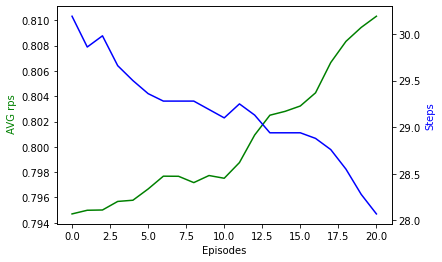

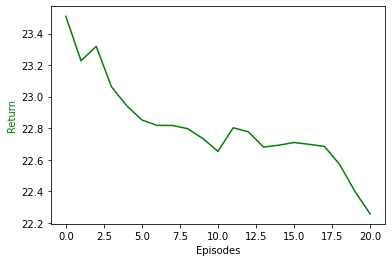

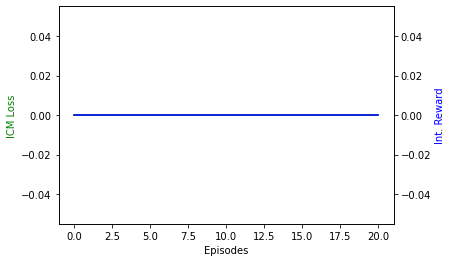

Total number of Episods: 120
Total number of steps: 3499


In [ ]:
#D3QN PER Agent training
epsilon = 1.0
update_every = 200
buffer_size = 25000
batch_size = 32
num_episodes = 120
num_episodes_to_min_epsilon = 20
obs_shape = (4,128,128)
repeat = 4
lr = 0.0001
gamma = 0.99
eps_min = 0.1
beta_add = (1-0.4)/num_episodes
eps_dec = (epsilon - eps_min) / num_episodes_to_min_epsilon
stochastic_env = False
use_ICM = False


agent = D3qn_PER_agent(gamma=gamma, epsilon=epsilon, eps_min=eps_min, eps_dec =eps_dec, lr=lr, update_every=update_every,
                   buffer_size=buffer_size, obs_shape=obs_shape, batch_size = batch_size, use_ICM=use_ICM)


agent.set_beta_add(beta_add)
env_list = [env]

master_stats, _= train_super_agent(agent, num_episodes, env_list, stochastic_env=stochastic_env, repeat=repeat)
display_stats(master_stats, "highway v0")


In [ ]:
create_video(agent, env, repeat=repeat,stochastic_env=False, max_steps=100)

iteration: <built-in function iter>, action: 2, reward: 0.8167466354644327, done: False
{'speed': 25.0, 'crashed': False, 'action': 2, 'cost': 0.0}
iteration: <built-in function iter>, action: 2, reward: 0.8356205413147286, done: False
{'speed': 25.0, 'crashed': False, 'action': 2, 'cost': 0.0}
iteration: <built-in function iter>, action: 2, reward: 0.8631636753107591, done: False
{'speed': 25.0, 'crashed': False, 'action': 2, 'cost': 0.0}
iteration: <built-in function iter>, action: 2, reward: 0.8663952523191609, done: False
{'speed': 25.0, 'crashed': False, 'action': 2, 'cost': 0.0}
iteration: <built-in function iter>, action: 1, reward: 0.8666481296814439, done: False
{'speed': 25.0, 'crashed': False, 'action': 1, 'cost': 0.0}
iteration: <built-in function iter>, action: 1, reward: 0.8666654629734406, done: False
{'speed': 25.0, 'crashed': False, 'action': 1, 'cost': 0.0}
iteration: <built-in function iter>, action: 1, reward: 0.8666665901647815, done: False
{'speed': 25.0, 'crashed

## D3QN PER Multi Steps

In [ ]:
#D3QN PER Agent training
epsilon = 1.0
update_every = 200
buffer_size = 25000
batch_size = 32
num_episodes = 500
num_episodes_to_min_epsilon = 150
obs_shape = (4,128,128)
repeat = 2
lr = 0.00025
gamma = 0.99
eps_min = 0.1
beta_add = (1-0.4)/num_episodes
eps_dec = (epsilon - eps_min) / num_episodes_to_min_epsilon
stochastic_env = True
use_ICM = False


agent = D3qn_PER_N_Steps_agent(gamma=gamma, epsilon=epsilon, eps_min=eps_min, eps_dec =eps_dec, lr=lr, update_every=update_every,
                   buffer_size=buffer_size, obs_shape=obs_shape, batch_size = batch_size, use_ICM=use_ICM)

agent.set_beta_add(beta_add)
env_list = [env]

master_stats, _= train_super_agent(agent, num_episodes, env_list, stochastic_env=stochastic_env, repeat=repeat)
display_stats(master_stats, "highway v0")


In [ ]:
create_video(agent, env, repeat=2, stochastic_env=False, max_steps=100,is_ppo=False)

# EX2 - Highway-Env - Grayscale Image - Medium

In [ ]:
# Creating envirnment


#=============== DO NOT DELETE ===============
file = open('/content/highway-config/config_ex2.txt', 'r')
contents = file.read()
config2 = ast.literal_eval(contents)
file.close()
# ============================================

env = gym.make("highway-fast-v0")
env.configure(config2)

## DDQN Attempt

In [ ]:
#DDQN Agent training
epsilon = 1.0
update_every = 100
buffer_size = 25000
batch_size = 32
num_episodes = 200
num_episodes_to_min_epsilon = 120
obs_shape = (4,128,128)
stochastic_env = True
repeat = 2
lr = 0.0001
gamma = 0.99
eps_min = 0.1
eps_dec = (epsilon - eps_min) / num_episodes_to_min_epsilon

agent = ddqn_agent(gamma=gamma, epsilon=epsilon, eps_min=eps_min, eps_dec =eps_dec, lr=lr, update_every=update_every,
                   buffer_size=buffer_size, obs_shape=obs_shape, batch_size = batch_size)

env_list = [env]

master_stats, _= train_super_agent(agent, num_episodes, env_list, stochastic_env=stochastic_env, repeat=repeat)
display_stats(master_stats, "highway v0")

In [ ]:
create_video(agent, env, repeat=repeat, stochastic_env=False, max_steps=100)

## D3QN Attempt

In [ ]:
#D3QN Agent training
epsilon = 1.0
update_every = 200
buffer_size = 25000
batch_size = 32
num_episodes = 120
num_episodes_to_min_epsilon = 70
obs_shape = (4,128,128)
repeat = 4
lr = 0.00025
gamma = 0.99
eps_min = 0.1
eps_dec = (epsilon - eps_min) / num_episodes_to_min_epsilon
stochastic_env=True
use_ICM = False

agent = D3qn_agent(gamma=gamma, epsilon=epsilon, eps_min=eps_min, eps_dec =eps_dec, lr=lr, update_every=update_every,
                   buffer_size=buffer_size, obs_shape=obs_shape, batch_size = batch_size, use_ICM=use_ICM)

env_list = [env]

master_stats, _= train_super_agent(agent, num_episodes, env_list, stochastic_env=stochastic_env, repeat=repeat)
display_stats(master_stats, "highway v0")

In [ ]:
create_video(agent, env, repeat=repeat, stochastic_env=False, max_steps=100)

## D3QN PER Attempt

In [ ]:
#D3QN PER Agent training
epsilon = 1.0
update_every = 200
buffer_size = 25000
batch_size = 32
num_episodes = 120
num_episodes_to_min_epsilon = 20
obs_shape = (4,128,128)
repeat = 4
lr = 0.0001
gamma = 0.99
eps_min = 0.1
beta_add = (1-0.4)/num_episodes
eps_dec = (epsilon - eps_min) / num_episodes_to_min_epsilon
stochastic_env = False
use_ICM = False


agent = D3qn_PER_agent(gamma=gamma, epsilon=epsilon, eps_min=eps_min, eps_dec =eps_dec, lr=lr, update_every=update_every,
                   buffer_size=buffer_size, obs_shape=obs_shape, batch_size = batch_size, use_ICM=use_ICM)


agent.set_beta_add(beta_add)
env_list = [env]

master_stats, _= train_super_agent(agent, num_episodes, env_list, stochastic_env=stochastic_env, repeat=repeat)
display_stats(master_stats, "highway v0")


In [ ]:
create_video(agent, env, repeat=repeat,stochastic_env=False, max_steps=100)

## PPO

highway-fast-v0
9216
9216
(5, 5)
(4, 128, 128)
episode 0 score 20.0 avg score 20.0 time_steps 23 learning_steps 0
(4, 128, 128)
episode 1 score 73.4 avg score 46.7 time_steps 100 learning_steps 5
(4, 128, 128)
episode 2 score 77.3 avg score 56.9 time_steps 90 learning_steps 8
(4, 128, 128)
episode 3 score 18.1 avg score 47.2 time_steps 22 learning_steps 9
(4, 128, 128)
episode 4 score 44.3 avg score 46.6 time_steps 52 learning_steps 11
(4, 128, 128)
episode 5 score 6.8 avg score 40.0 time_steps 9 learning_steps 12
(4, 128, 128)
episode 6 score 2.7 avg score 34.7 time_steps 4 learning_steps 12
(4, 128, 128)
episode 7 score 25.2 avg score 33.5 time_steps 30 learning_steps 13
(4, 128, 128)
episode 8 score 52.7 avg score 35.6 time_steps 62 learning_steps 16
(4, 128, 128)
episode 9 score 10.3 avg score 33.1 time_steps 13 learning_steps 16
(4, 128, 128)
episode 10 score 36.3 avg score 33.4 time_steps 43 learning_steps 18
(4, 128, 128)
episode 11 score 18.3 avg score 32.1 time_steps 22 learni

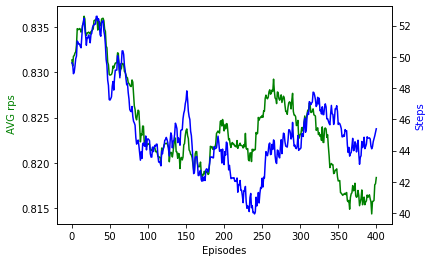

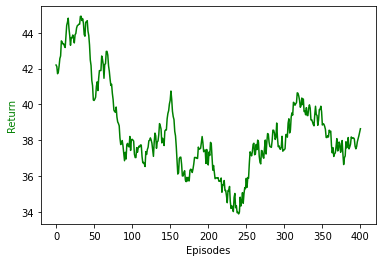

Total number of steps: 22695


In [ ]:
num_episods = 500
score_history, steps_hist, sps_hist, agent = train_ppo_agent(num_episods, [env], stochastic_env=False, repeat=1, verbose=True)


sliding_window_size = 100

return_avg = np.convolve(np.array(score_history), np.ones(sliding_window_size)/sliding_window_size, mode='valid')
rps_avg = np.convolve(np.array(sps_hist), np.ones(sliding_window_size)/sliding_window_size, mode='valid')
steps_avg = np.convolve(np.array(steps_hist), np.ones(sliding_window_size)/sliding_window_size, mode='valid')
#icm_loss_avg = np.convolve(np.array(icm_loss_hist), np.ones(sliding_window_size)/sliding_window_size, mode='valid')
#r_i_t_avg = np.convolve(np.array(r_i_t_hist), np.ones(sliding_window_size)/sliding_window_size, mode='valid')

display_setp_hist(rps_avg, steps_avg)
display_returns_hist(return_avg)
#display_icm_hist(icm_loss_avg, r_i_t_avg)

print(f"Total number of steps: {sum(steps_hist)}")

In [ ]:
create_video(agent, env, repeat=1, stochastic_env=False, max_steps=100,is_ppo=True)

2
iteration: <built-in function iter>, action: 2, reward: 0.850079968797766, done: False
{'speed': 25.0, 'crashed': False, 'action': 2, 'cost': 0.0}
2
iteration: <built-in function iter>, action: 2, reward: 0.864535573491389, done: False
{'speed': 25.0, 'crashed': False, 'action': 2, 'cost': 0.0}
2
iteration: <built-in function iter>, action: 2, reward: 0.866495350253388, done: False
{'speed': 25.0, 'crashed': False, 'action': 2, 'cost': 0.0}
2
iteration: <built-in function iter>, action: 2, reward: 0.8666548033058176, done: False
{'speed': 25.0, 'crashed': False, 'action': 2, 'cost': 0.0}
2
iteration: <built-in function iter>, action: 2, reward: 0.8666658918962077, done: False
{'speed': 25.0, 'crashed': False, 'action': 2, 'cost': 0.0}
2
iteration: <built-in function iter>, action: 2, reward: 0.8666666173034995, done: False
{'speed': 25.0, 'crashed': False, 'action': 2, 'cost': 0.0}
2
iteration: <built-in function iter>, action: 2, reward: 0.8666666635551757, done: False
{'speed': 25.

## Notebook things

In [ ]:
#=============== DO NOT DELETE ===============
file = open('/content/highway-config/config_ex2.txt', 'r')
contents = file.read()
config2 = ast.literal_eval(contents)
file.close()
# ============================================

env = gym.make("highway-fast-v0")
env.configure(config2)

obs = env.reset()
for j in range(10):
    sam_act = env.action_space.sample()
    obs, _, _, _ = env.step(sam_act)

    _, axes = plt.subplots(ncols=4, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))

env = wrap_env(env)
env.reset()
done = False
iter = 0
while (iter < 40) or not done:
  if done:
    break
  iter +=1
  action = env.action_space.sample()
  observation, reward, done, _ = env.step(action)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  print(f'iteration: {iter}, action: {action}, reward: {reward}, done: {done}')

# Ex3 - Super Highway Agent

In [ ]:
#=============== DO NOT DELETE ===============
file = open('/content/highway-config/config_ex3.txt', 'r')
contents = file.read()
config3 = ast.literal_eval(contents)
file.close()
# ============================================

# init envs #
env_highway = gym.make("highway-fast-v0")
env_highway.configure(config3)

env_marge = gym.make("merge-v0")
env_marge.configure(config3)

env_roundabout = gym.make("roundabout-v0")
env_roundabout.configure(config3)

envs_list = [env_highway, env_marge, env_roundabout]

## DDQN Attempt

In [ ]:
#DDQN Agent training
epsilon = 1.0
update_every = 100
buffer_size = 25000
batch_size = 32
num_episodes = 200
num_episodes_to_min_epsilon = 120
obs_shape = (4,128,128)

lr = 0.001
gamma = 0.99
eps_min = 0.1
repeat = 4
eps_dec = (epsilon - eps_min) / num_episodes_to_min_epsilon
stochastic_env = True

agent = ddqn_agent(gamma=gamma, epsilon=epsilon, eps_min=eps_min, eps_dec =eps_dec, lr=lr, update_every=update_every,
                   buffer_size=buffer_size, obs_shape=obs_shape, batch_size = batch_size)

master_stats, envs_list = train_super_agent(agent, num_episodes, envs_list, stochastic_env=stochastic_env, repeat=repeat)

display_stats(master_stats, "master")

for env in envs_list:
  env_name = env.unwrapped.spec.id
  display_stats(envs_stats[env_name], env_name)

In [ ]:
create_video(agent, env_roundabout, repeat=repeat, stochastic_env=False, max_steps=200)

## D3QN Attempt

In [ ]:
#D3QN Agent training
epsilon = 1.0
update_every = 200
buffer_size = 25000
batch_size = 32
num_episodes = 2000
num_episodes_to_min_epsilon = 1000
obs_shape = (4,128,128)
repeat = 4
lr = 0.0001
gamma = 0.99
eps_min = 0.1
eps_dec = (epsilon - eps_min) / num_episodes_to_min_epsilon
stochastic_env=False
use_ICM = False


agent = D3qn_agent(gamma=gamma, epsilon=epsilon, eps_min=eps_min, eps_dec =eps_dec, lr=lr, update_every=update_every,
                   buffer_size=buffer_size, obs_shape=obs_shape, batch_size = batch_size, use_ICM=use_ICM)

master_stats, envs_stats = train_super_agent(agent, num_episodes, envs_list, stochastic_env=stochastic_env, repeat=repeat)



display_stats(master_stats, "master")

for env in envs_list:
  env_name = env.unwrapped.spec.id
  display_stats(envs_stats[env_name], env_name)


In [ ]:
create_video(agent, env_roundabout, repeat=repeat, stochastic_env=False, max_steps=200)

## D3QN PER Attempt

In [ ]:
#D3QN PER Agent training
epsilon = 1.0
update_every = 200
buffer_size = 25000
batch_size = 32
num_episodes = 150
num_episodes_to_min_epsilon = 100
obs_shape = (4,128,128)
repeat = 4
lr = 0.00025
gamma = 0.99
eps_min = 0.1
eps_dec = (epsilon - eps_min) / num_episodes_to_min_epsilon
beta_add = (1-0.4)/num_episodes
stochastic_env = False
use_ICM = False


agent = D3qn_PER_agent(gamma=gamma, epsilon=epsilon, eps_min=eps_min, eps_dec =eps_dec, lr=lr, update_every=update_every,
                   buffer_size=buffer_size, obs_shape=obs_shape, batch_size = batch_size, use_ICM=use_ICM)


agent.set_beta_add(beta_add)

agent = D3qn_agent(gamma=gamma, epsilon=epsilon, eps_min=eps_min, eps_dec =eps_dec, lr=lr, update_every=update_every,
                   buffer_size=buffer_size, obs_shape=obs_shape, batch_size = batch_size, use_ICM=use_ICM)

master_stats, envs_stats = train_super_agent(agent, num_episodes, envs_list, stochastic_env=stochastic_env, repeat=repeat)

display_stats(master_stats, "master")

for env in envs_list:
  env_name = env.unwrapped.spec.id
  display_stats(envs_stats[env_name], env_name)


In [ ]:
create_video(agent, env, repeat=repeat,stochastic_env=False, max_steps=100)

## notebook things

### Ex3 - Highway-Env

iteration: 1, action: 4, reward: 0.7592592592592592, done: False
iteration: 2, action: 3, reward: 0.8004115226337448, done: False
iteration: 3, action: 3, reward: 0.8927754915409237, done: False
iteration: 4, action: 3, reward: 0.9338261443885587, done: False
iteration: 5, action: 4, reward: 0.8779968049134336, done: False
iteration: 6, action: 1, reward: 0.8531837651467112, done: False
iteration: 7, action: 3, reward: 0.9162298215466863, done: False
iteration: 8, action: 4, reward: 0.8701762169837125, done: False
iteration: 9, action: 0, reward: 0.8002313449534647, done: False
iteration: 10, action: 1, reward: 0.8050932609256627, done: False
iteration: 11, action: 0, reward: 0.8030547674505141, done: False
iteration: 12, action: 3, reward: 0.8754993427060419, done: False
iteration: 13, action: 1, reward: 0.24096762461332788, done: True


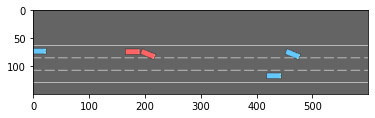

In [ ]:
env = gym.make("highway-fast-v0")
env.configure(config3)

env = wrap_env(env)
env.reset()
done = False
iter = 0
while (iter < 10) or not done:
  if done:
    break
  iter +=1
  action = env.action_space.sample()
  observation, reward, done, _ = env.step(action)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  print(f'iteration: {iter}, action: {action}, reward: {reward}, done: {done}')

### Play video

In [ ]:
env.close()
show_video()

### Ex3 - Merge-Env

iteration: 1, action: 4, reward: 0.9444444444444444, done: False
iteration: 2, action: 3, reward: 1.0, done: False
iteration: 3, action: 2, reward: 0.9722222222222222, done: False
iteration: 4, action: 2, reward: 0.9722222222222222, done: False
iteration: 5, action: 0, reward: 0.9722222222222222, done: False
iteration: 6, action: 3, reward: 0.9444444444444444, done: False
iteration: 7, action: 2, reward: 0.9722222222222222, done: False
iteration: 8, action: 0, reward: 0.9166666666666666, done: False
iteration: 9, action: 0, reward: 0.9166666666666666, done: False
iteration: 10, action: 0, reward: 0.9166666666666666, done: False
iteration: 11, action: 4, reward: 0.8534026449516219, done: False
iteration: 12, action: 4, reward: 0.7719211634701405, done: False
iteration: 13, action: 4, reward: 0.7459952375442147, done: False
iteration: 14, action: 2, reward: 0.7478470893960666, done: False
iteration: 15, action: 1, reward: 0.7496989412479185, done: False
iteration: 16, action: 0, reward: 

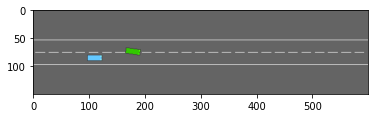

In [ ]:
env = gym.make("merge-v0")
env.configure(config3)

env = wrap_env(env)
env.reset()
done = False
iter = 0

while (iter < 10) or not done:
  if done:
    break
  iter +=1
  action = env.action_space.sample()
  observation, reward, done, _ = env.step(action)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  print(f'iteration: {iter}, action: {action}, reward: {reward}, done: {done}')

### Play video


In [ ]:
env.close()
show_video()

### Ex3 - Roundabout-Env

iteration: 1, action: 1, reward: 0.9200000000000002, done: False
iteration: 2, action: 2, reward: 0.8800000000000001, done: False
iteration: 3, action: 0, reward: 0.8800000000000001, done: False
iteration: 4, action: 4, reward: 0.8400000000000001, done: False
iteration: 5, action: 0, reward: 0.8, done: False
iteration: 6, action: 3, reward: 0.9200000000000002, done: False
iteration: 7, action: 1, reward: 0.9200000000000002, done: False
iteration: 8, action: 2, reward: 0.8800000000000001, done: False
iteration: 9, action: 1, reward: 0.9200000000000002, done: False
iteration: 10, action: 0, reward: 0.8800000000000001, done: False
iteration: 11, action: 4, reward: 0.8400000000000001, done: False
iteration: 12, action: 3, reward: 0.9200000000000002, done: False
iteration: 13, action: 0, reward: 0.8800000000000001, done: False
iteration: 14, action: 4, reward: 0.8400000000000001, done: False
iteration: 15, action: 2, reward: 0.8, done: False
iteration: 16, action: 3, reward: 0.9200000000000

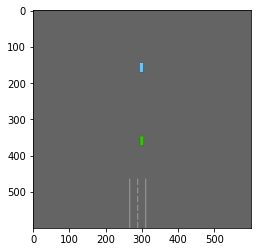

In [ ]:
env = gym.make("roundabout-v0")
env.configure(config3)
env = wrap_env(env)
env.reset()
done = False
iter = 0
while (iter < 40) and not done:
  if done:
    break
  iter +=1
  action = env.action_space.sample()
  observation, reward, done, _ = env.step(action)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  print(f'iteration: {iter}, action: {action}, reward: {reward}, done: {done}')

### Play video

In [ ]:
env.close()
show_video()

# Traning - where all main training are done.

---



In [ ]:
def multi_traniner(envs_lists, testing=False):
  epsilon = 1.0
  update_every = 200
  buffer_size = 25000
  batch_size = 32
  num_episodes = 6000
  num_episodes_to_min_epsilon = 1500
  obs_shape = (4,128,128)
  gamma = 0.99
  eps_min = 0.1
  beta_add = (1-0.4)/num_episodes
  eps_dec = (epsilon - eps_min) / num_episodes_to_min_epsilon
  use_ICM = False
  lr = 0.0001
  repeat = 1

  for i, (envs, stochastic_env) in enumerate([(envs_lists[0],True), (envs_lists[1], False), (envs_lists[2], False)]):
    if i >0:
      repeat = 4

      num_episodes = 3000
      num_episodes_to_min_epsilon = 600
      eps_dec = (epsilon - eps_min) / num_episodes_to_min_epsilon
      name=f'TEST_03_net_rep_{repeat}_EX_{i+1}'

      if testing:
        num_episodes = 10

      print(f'EX_{i+1 } env {envs}')
      d3qn_per_n_steps_agent = D3qn_PER_N_Steps_agent(gamma=gamma, epsilon=epsilon, eps_min=eps_min, eps_dec =eps_dec, lr=lr, update_every=update_every,
                            buffer_size=buffer_size, obs_shape=obs_shape, batch_size = batch_size, use_ICM=False, name=name)

      d3qn_per_n_steps_agent.set_beta_add(beta_add)



      master_stats, envs_stats = train_super_agent(d3qn_per_n_steps_agent, num_episodes, envs, stochastic_env=stochastic_env, repeat=repeat, verbose=False)





      display_stats(master_stats, f"Ex:{i+1}, agnet: {type(d3qn_per_n_steps_agent).__name__}, lr: {lr} repeat: {repeat}, num_episodes: {num_episodes}, stochastic_env = {stochastic_env}")
      if i == 2:
        for env in envs:
          env_name = env.unwrapped.spec.id
          display_stats(envs_stats[env_name], env_name)
        print("##########################################################################")



In [ ]:
#create the env
#=============== DO NOT DELETE ===============
file = open('/content/highway-config/config_ex1.txt', 'r')
contents = file.read()
config1 = ast.literal_eval(contents)
file.close()
# ============================================

env1 = gym.make("highway-fast-v0")
env1.configure(config1)

In [ ]:
#=============== DO NOT DELETE ===============
file = open('/content/highway-config/config_ex2.txt', 'r')
contents = file.read()
config2 = ast.literal_eval(contents)
file.close()
# ============================================

env2 = gym.make("highway-fast-v0")
env2.configure(config2)

In [ ]:
#=============== DO NOT DELETE ===============
file = open('/content/highway-config/config_ex3.txt', 'r')
contents = file.read()
config3 = ast.literal_eval(contents)
file.close()
# ============================================

# init envs #
env_highway = gym.make("highway-fast-v0")
env_highway.configure(config3)

env_marge = gym.make("merge-v0")
env_marge.configure(config3)

env_roundabout = gym.make("roundabout-v0")
env_roundabout.configure(config3)

envs_list = [env_highway, env_marge, env_roundabout]

In [ ]:
envs_lists = [[env1], [env2], envs_list]
multi_traniner(envs_lists,testing=False)

EX_2 env [<OrderEnforcing<HighwayEnvFast<highway-fast-v0>>>]
9216
9216


KeyboardInterrupt: ignored

# Testing Models

In [ ]:
def load_agent(wights_file_name=None):
  epsilon = 1.0
  update_every = 200
  buffer_size = 25000
  batch_size = 32
  num_episodes = 6000
  num_episodes_to_min_epsilon = 1500
  obs_shape = (4,128,128)
  gamma = 0.99
  eps_min = 0.1
  beta_add = (1-0.4)/num_episodes
  eps_dec = (epsilon - eps_min) / num_episodes_to_min_epsilon
  use_ICM = False
  lr = 0.00025
  repeat = 4

  agent = D3qn_PER_N_Steps_agent(gamma=gamma, epsilon=epsilon, eps_min=eps_min, eps_dec =eps_dec, lr=lr, update_every=update_every,
                          buffer_size=buffer_size, obs_shape=obs_shape, batch_size = batch_size, use_ICM=False)

  agent.set_beta_add(beta_add)

  agent.load_models(file_name=wights_file_name)

  return agent


In [ ]:
def create_envs():
  #create the env
  #=============== DO NOT DELETE ===============
  file = open('/content/highway-config/config_ex1.txt', 'r')
  contents = file.read()
  config1 = ast.literal_eval(contents)
  file.close()
  # ============================================

  env1 = gym.make("highway-fast-v0")
  env1.configure(config1)

  #=============== DO NOT DELETE ===============
  file = open('/content/highway-config/config_ex2.txt', 'r')
  contents = file.read()
  config2 = ast.literal_eval(contents)
  file.close()
  # ============================================

  env2 = gym.make("highway-fast-v0")
  env2.configure(config2)

  #=============== DO NOT DELETE ===============
  file = open('/content/highway-config/config_ex3.txt', 'r')
  contents = file.read()
  config3 = ast.literal_eval(contents)
  file.close()
  # ============================================

  # init envs #
  env_highway = gym.make("highway-fast-v0")
  env_highway.configure(config3)

  env_marge = gym.make("merge-v0")
  env_marge.configure(config3)

  env_roundabout = gym.make("roundabout-v0")
  env_roundabout.configure(config3)

  envs_list = [env_highway, env_marge, env_roundabout]

  envs_lists = [[env1], [env2], envs_list]

  return envs_lists

In [ ]:
def load_all_agents(ex1_file_name, ex2_file_name, ex3_file_name):
  agent_ex1 = load_agent(ex1_file_name)
  agent_ex2 = load_agent(ex2_file_name)
  agent_ex3 = load_agent(ex3_file_name)

  return agent_ex1, agent_ex2, agent_ex3

def load_agents_and_test(ex1_file_name, ex2_file_name, ex3_file_name):

  envs_exs_lists =  create_envs()
  num_episodes = 120


  agent_ex1, agent_ex2, agent_ex3 = load_all_agents(ex1_file_name, ex2_file_name, ex3_file_name)
  print("start Testing")
  print("Test 1")
  ex1_stats = test_agent(agent_ex1, num_episodes, envs_exs_lists[0][0], stochastic_env=True, max_steps=500, repeat=4, verbose=False)
  print("Test 2")
  ex2_stats = test_agent(agent_ex2, num_episodes, envs_exs_lists[1][0], stochastic_env=False, max_steps=500, repeat=4, verbose=False)
  print("Test 3_1")
  ex3_ev1_stats = test_agent(agent_ex3, num_episodes, envs_exs_lists[2][0], stochastic_env=False, max_steps=500, repeat=4, verbose=False)
  print("Test 3_2")
  ex3_ev2_stats = test_agent(agent_ex3, num_episodes, envs_exs_lists[2][1], stochastic_env=False, max_steps=40, repeat=4, verbose=False)
  print("Test 3_3")
  ex3_ev3_stats = test_agent(agent_ex3, num_episodes, envs_exs_lists[2][2], stochastic_env=False, max_steps=40, repeat=4, verbose=False)
  stats = (ex1_stats, ex2_stats, ex3_ev1_stats, ex3_ev2_stats, ex3_ev3_stats)
  agents = (agent_ex1, agent_ex2, agent_ex3)
  return agents, stats


In [ ]:
#insert your wightes files loactions
ex1_file_name = '/content/drive/MyDrive/RL_FINAL/final_wights_ex1.pt'
ex2_file_name = '/content/drive/MyDrive/RL_FINAL/final_wights_ex2.pt'
ex3_file_name = '/content/drive/MyDrive/RL_FINAL/final_wights_ex3.pt'


envs_exs_lists =  create_envs()
agents, stats = load_agents_and_test(ex1_file_name, ex2_file_name, ex3_file_name)
ex1_stats, ex2_stats, ex3_ev1_stats, ex3_ev2_stats, ex3_ev3_stats = stats
agent_ex1, agent_ex2, agent_ex3 = agents

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
start Testing
Test 1
Test 2
Test 3_1
Test 3_2
Test 3_3


EX1


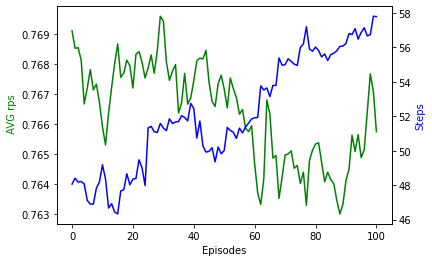

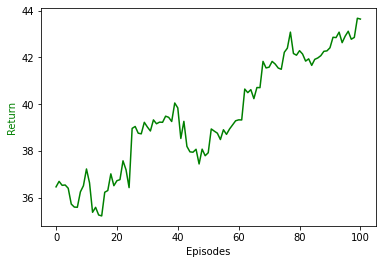

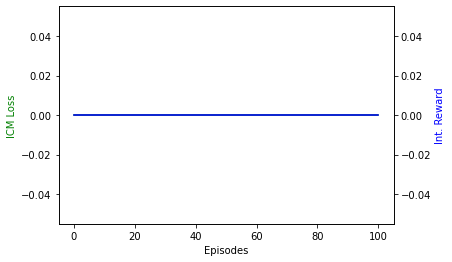

Total number of Episods: 200
Total number of steps: 10584


In [ ]:
# Agent 1 final results
display_stats(ex1_stats, "EX1")
create_video(agent_ex1, envs_exs_lists[0][0], repeat=4, stochastic_env=True, max_steps=500)

EX2


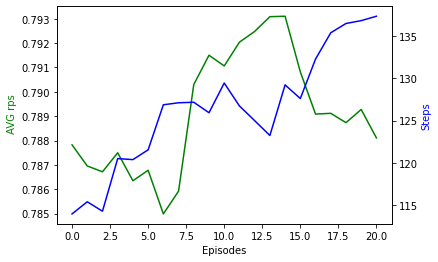

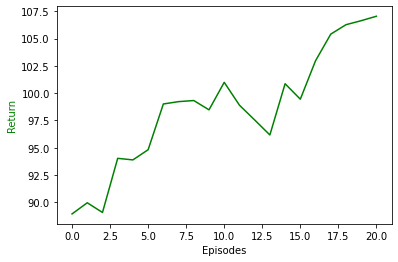

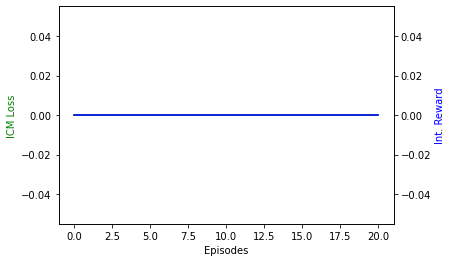

Total number of Episods: 70
Total number of steps: 8621


In [ ]:
display_stats(ex2_stats, "EX2")
create_video(agent_ex2, envs_exs_lists[1][0], repeat=2, stochastic_env=False, max_steps=500)

EX3 env 1


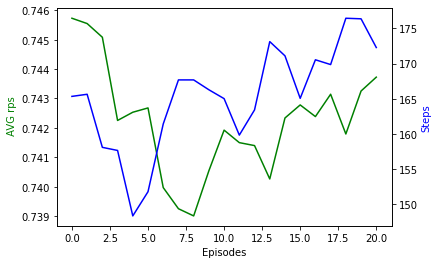

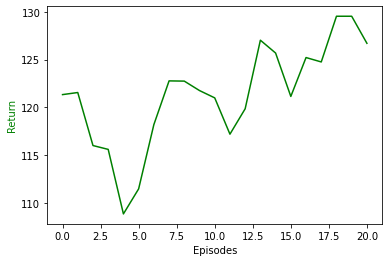

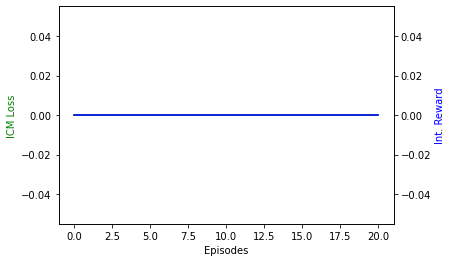

Total number of Episods: 70
Total number of steps: 11773


In [ ]:
display_stats(ex3_ev1_stats, "EX3 env 1")
create_video(agent_ex3, envs_exs_lists[2][0], repeat=2, stochastic_env=False, max_steps=500)

EX3 env 2


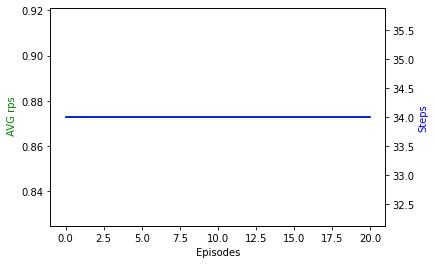

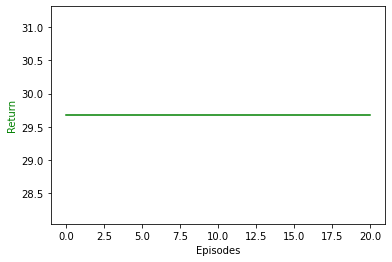

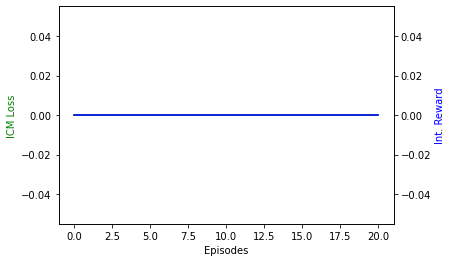

Total number of Episods: 70
Total number of steps: 2380


In [ ]:
display_stats(ex3_ev2_stats, "EX3 env 2")
create_video(agent_ex3, envs_exs_lists[2][1], repeat=2, stochastic_env=False, max_steps=50)

EX3 env 3


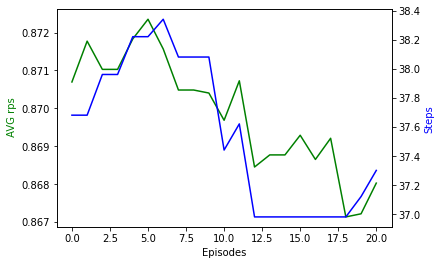

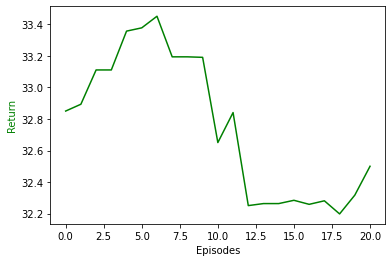

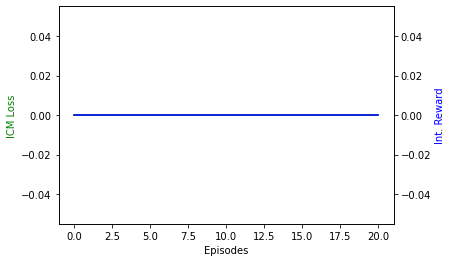

Total number of Episods: 70
Total number of steps: 2602


In [ ]:
display_stats(ex3_ev3_stats, "EX3 env 3")
create_video(agent_ex3, envs_exs_lists[2][2], repeat=2, stochastic_env=False, max_steps=60)

In [ ]:
#insert your wight files loactions
ex1_file_name = "enter here the path of ex1 agent wights"
ex2_file_name = "enter here the path of ex2 agent wights"
ex3_file_name = "enter here the path of ex3 agent wights"

agent_ex1, agent_ex2, agent_ex3 = load_all_agents(ex1_file_name, ex2_file_name, ex3_file_name)